## Reading generated images

In [7]:
import io
import cv2
import json
import time
import requests
import numpy as np
from matplotlib import ticker
from matplotlib import pyplot as plt
from IPython.display import clear_output
from lib.util import to_ai_url, setup_plt
from lib.load import index_urls, gen_images
from lib.truth import to_truth
from lib.ai import gen_results

USE_AWS_AI = False

print("testing", "on aws" if (USE_AWS_AI) else "locally")
plt.rcParams["figure.figsize"] = (16,16)
plt.rcParams["figure.dpi"] = 40


testing locally


In [3]:
NUM_READ = -1
NUM_READ = 5 # TODO

images = []
sources = index_urls('merged.json', NUM_READ)
print(f'Loading ≤ {NUM_READ} images...')
image_gen = gen_images(sources)

for src in sources:
    img = None
    try: img = next(image_gen)
    except StopIteration: break
    images.append(img)
    if len(images) % 10 == 0:
        clear_output(wait=True)
        print(round(100*len(images)/len(sources)),'%')

print('Loaded', len(images), 'images!')

Loading ≤ 5 images...
Loaded 5 images!


## Custom OCR

In [4]:
try: images
except NameError:
    raise(Exception("Please run prior cell"))
try: USE_AWS_AI
except NameError:
    raise(Exception("Please run first cell"))

for result in gen_results(USE_AWS_AI, images):
   print(result)

Using Custom AI: http://localhost:80/


KeyboardInterrupt: 

## EasyOCR

[[[541, 610], [762, 610], [762, 711], [541, 711]]]
['allspice']


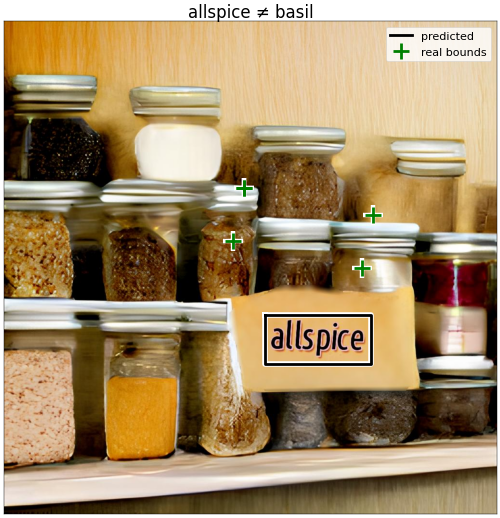

DONE


In [8]:
import easyocr

try: images
except NameError:
    raise(Exception("Please run prior cell"))

N_VIZ = len(images)
DELAY_VIZ = 0.0
print('LOADING MODEL...')
reader = easyocr.Reader(['en'])
def result_to_box(result):
    for r in result:
        yield np.round(r[0]).astype(int).tolist()
def result_to_words(result):
    # TODO -- fix source dataset
    ok_err = {
        'llspice': 'allspice'
    }
    for r in result:
        yield ok_err.get(r[1],r[1])

truth = to_truth(sources)
samples = zip(truth, images)

result_values = []

for (i, (real, img)) in enumerate(samples):
    real_text = real["text"]
    real_box = real["box"]
    result = reader.readtext(img)
    result_box = list(result_to_box(result))
    result_words = list(result_to_words(result))
    result_text = ' '.join(result_words)
    result_values.append({
        "text": result_text,
        "bounds": result_box,
    })
    if len(result_values) % 10 == 0:
        print(round(100*len(result_values)/len(images)),'%')
    if (i >= N_VIZ):
        continue
    time.sleep(DELAY_VIZ)
    setup_plt()
    clear_output(wait=True)
    plt.imshow(img)

    # Calculate title
    correct = result_text == real_text
    sep = "==" if correct else "≠"
    plt.title(f'{result_text} {sep} {real_text}', fontsize = 30)

    print(result_box)
    print(result_words)
    # Draw predicted bounding boxes
    for (res_i, res_box) in enumerate(result_box):
        c = 'k'
        xs, ys = zip(*res_box)
        xs += (xs[0],)
        ys += (ys[0],)            
        l = 'predicted' if res_i == 0 else f'_res_{res_i}'
        plt.plot(xs,ys, 'w', label='_res_bg', linewidth=10)
        plt.plot(xs,ys, 'k', label=l, linewidth=5)
    
    # Draw real bounding boxes
    for (rea_i, rea_box) in enumerate(real_box):
        xs, ys = zip(*rea_box)
        xs += (xs[0],)
        ys += (ys[0],)    
        l = 'real bounds' if rea_i == 0 else f'_rea_{rea_i}'
        plt.plot(xs,ys, 'w+', label='_real_bg', mew=8, ms=35)
        plt.plot(xs,ys, 'g+', label=l, mew=5, ms=30)
        
    plt.legend(fontsize = 20)
    plt.show()
print('DONE')

# Evaluation

In [ ]:
ious = []

try: images
except NameError:
    raise(Exception("Please run prior cell"))
try: real_values
except NameError:
    raise(Exception("Please run prior cell"))
try: result_values
except NameError:
    raise(Exception("Please run prior cell"))
    
# Assume all same shape
rea_canvas = np.zeros(images[0].shape[:2], dtype=np.float32)
res_canvas = np.zeros(images[0].shape[:2], dtype=np.float32)

for (rea, res) in zip(real_values, result_values):
    rea_canvas[:,:] = 0
    res_canvas[:,:] = 0
    # Render the real bounds
    for box in rea["bounds"]:
        cv2.fillPoly(rea_canvas, pts =[np.array(box)], color =(1))
    # Render the result bounds
    for box in res["bounds"]:
        cv2.fillPoly(res_canvas, pts =[np.array(box)], color =(1))

    # Calculate the union
    union = np.logical_or(rea_canvas > 0, res_canvas > 0)
    intersection = np.logical_and(rea_canvas > 0, res_canvas > 0)
    iou = round(100 * (intersection.sum() / union.sum()))
    ious.append(iou)
    if len(ious) % 10 == 0:
        print(round(100*len(ious)/len(real_values)),'%')

setup_plt(True)
bin_range = list(range(0,100,10))
plt.gca().xaxis.grid(True, color='k')
plt.gca().yaxis.grid(True)
plt.hist(ious, bins = bin_range, density = True)
plt.title(f'Histogram of IOU (intersection over Union)', fontsize = 50)
plt.tick_params(axis='both', which='major', labelsize = 30)
plt.xticks(bin_range, [f'{x//10}/10' for x in bin_range])

plt.xticks(bin_range)
plt.xlabel("IOU as ratio", fontsize=40)
plt.ylabel("Frequency of range", fontsize=40)
plt.show() # TODO
    

In [ ]:
try: ious
except NameError:
    raise(Exception("Please run prior cell"))
    
MEAN_IOU = np.mean(ious)
TEXT_EQUALITY = [a["text"] == b["text"] for (a, b) in zip(real_values, result_values)]
TEXT_ACCURACY = int(np.array(TEXT_EQUALITY, dtype=bool).sum())/len(TEXT_EQUALITY)
MEAN_CORRECT_IOU = np.mean(np.array(ious)[TEXT_EQUALITY])

print(f'{round(MEAN_IOU, 3)}% mean IOU')
print(f'   {round(MEAN_CORRECT_IOU, 3)}% for true predictions')
print(f'\n{round(TEXT_ACCURACY*100, 3)}% text accuracy')

In [ ]:
from random import sample as samp
import openai
import time
import json
import re
openai.api_key = OPENAI_KEY

In [ ]:
try: TEXT_EQUALITY
except NameError:
    raise(Exception("Please run prior cell"))

N_GPT = 5
DELAY_GPT = 5.0

ai_server_url = to_ai_url(USE_AWS_AI)
print(f'Using Custom AI: {ai_server_url}')

#api request instructions
def chat_with_gpt(spices):
    endpoint = f'{ai_server_url}recipe'
    response = requests.post(endpoint, json.dumps({
        "spices": spices
    }))
    res_data = response.json()
    return res_data
  

found_spices = set([v["text"] for (t,v) in zip(TEXT_EQUALITY, result_values) if t])
spice_lists = [samp(list(found_spices),samp([2,3,4],1)[0]) for _ in range(N_GPT)]
    
for spices in spice_lists:
    clear_output(wait=True)
    print('INPUT SPICES:')
    print('-', ', '.join(spices))
    output = chat_with_gpt(spices)
    print('\nOUTPUT RECIPE:')
    print(f'{len(output["spices"]) - len(spices)} added spices')
    print(f'{len(output["ingredients"])} added ingredients')
    print()
    print(output["text"])
    time.sleep(DELAY_GPT)
    print('\n')